# IMPORTING LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

# IMPORTING DATASET 

In [3]:
stock = pd.read_csv("meb.csv")

In [4]:
stock.head(2)

,Date,Open,High,Low,Close,Volume
0,2018-01-01,67.0,67.69,67.0,67.20,1051500
1,2018-01-02,67.0,70.56,67.0,70.56,51500


## extracting out dates for later use[visualization and forecast purpose]

In [5]:
import datetime as dt

In [6]:
dates = list(stock['Date'])
dates = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

In [7]:
print("Starting date of record : " , dates[0])
print("Last date of record : " , dates[-1])
print("Total days n(records) = ",len(dates))

Starting date of record :  2018-01-01
Last date of record :  2022-05-18
Total days n(records) =  1071


## creating dataset of chosen features to work ahead with LSTM-model

In [8]:
features = list(stock)[1:-1]

In [9]:
data = stock[features]

In [10]:
data.head(2)

,Open,High,Low,Close
0,67.0,67.69,67.0,67.20
1,67.0,70.56,67.0,70.56


In [11]:
print("The features selected to train the model are : ", data.columns.values)

The features selected to train the model are :  ['Open' 'High' 'Low' 'Close']


# DATA PRE-PROCESSING 

In [12]:
data = data.astype(float)

In [13]:
data.head(2)

,Open,High,Low,Close
0,67.0,67.69,67.0,67.20
1,67.0,70.56,67.0,70.56


In [14]:
dataset = data.values

In [15]:
dataset.shape

(1071, 4)

In [16]:
dataset[0]

array([67.  , 67.69, 67.  , 67.2 ])

In [17]:
dataset[:,0:1]

array([[ 67. ],
       [ 67. ],
       [ 71.5],
       ...,
       [134. ],
       [130.5],
       [128. ]])

# FEATURE SCALING

In [18]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc_dataset = sc.fit_transform(dataset)

pred_sc = StandardScaler()
pred_sc.fit_transform(dataset[:, 0:1 ]) #for output values

array([[-1.34376269],
       [-1.34376269],
       [-1.15187036],
       ...,
       [ 1.51330082],
       [ 1.36405123],
       [ 1.25744439]])

# INPUT-OUTPUT SPLIT FOR TIME SERIES ANALYSIS 

In [19]:
Xtrain = [] #trend to be analyzed
ytrain = [] #output for the given-trend

In [20]:
nFuture = 1 #60 #7 #30   # Number of days we want top predict into the future
nPast = 14 #90 #30 #100     # Number of past days we want to use to predict the future 

In [21]:
rows = data.shape[0]
cols = data.shape[1]

In [22]:
cols == dataset.shape[1]

True

In [23]:
cols

4

In [24]:
for i in range(nPast ,  rows - nFuture +1):
    Xtrain.append(sc_dataset[i - nPast : i , 0:cols])
    ytrain.append(sc_dataset[i + nFuture - 1 : i + nFuture , 0])

In [25]:
Xtrain = np.array(Xtrain)
ytrain = np.array(ytrain)

In [26]:
sc.inverse_transform([Xtrain[0][0]]) == dataset[0]

array([[ True,  True,  True,  True]])

In [27]:
pred_sc.inverse_transform([ytrain[0]])

array([[77.]])

In [28]:
Xtrain[nFuture + nPast - 1][0][0] == ytrain[0]

array([ True])

Now the Xtrain contains all of the given dataset , where as ytrain contains value of volumes to be predicted at gievn past and future figures

# MODEL TRAINING 

## IMPORTING LIBRARIES

In [29]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow.keras import optimizers

2022-05-26 05:02:47.713388: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-26 05:02:47.713427: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


## Training Model

In [30]:
from tensorflow import keras

In [31]:
model = Sequential()

#LAYERS
model.add(LSTM(units=128, return_sequences=True, input_shape=(Xtrain.shape[1] , Xtrain.shape[2]))) #first layer #nPast , cols
model.add(LSTM(units=64 , activation = "relu", return_sequences=True , kernel_regularizer=keras.regularizers.l2(0.001) )) #second layer
model.add(Dropout(0.5))
model.add(LSTM(units=32, activation = "relu", return_sequences=True , kernel_regularizer=keras.regularizers.l2(0.001) )) #second layer
model.add(Dropout(0.5))
model.add(LSTM(units=10,return_sequences=False )) #third layers

#DROPOUT
model.add(Dropout(0.5))

#OUTPUT
model.add(Dense(ytrain.shape[1] ,  name = "dense_out")) #output layer

2022-05-26 05:02:51.012603: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-26 05:02:51.012648: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-26 05:02:51.012692: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (huda): /proc/driver/nvidia/version does not exist
2022-05-26 05:02:51.014226: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 128)           68096     
                                                                 
 lstm_1 (LSTM)               (None, 14, 64)            49408     
                                                                 
 dropout (Dropout)           (None, 14, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 14, 32)            12416     
                                                                 
 dropout_1 (Dropout)         (None, 14, 32)            0         
                                                                 
 lstm_3 (LSTM)               (None, 10)                1720      
                                                                 
 dropout_2 (Dropout)         (None, 10)                0

## Compling NN 

In [33]:
from tensorflow.keras import losses

In [34]:
opmz = optimizers.Adam(learning_rate=0.001)
loss = losses.mean_squared_error

model.compile(optimizer = opmz , loss = loss)

## Fitting dataset to model 

In [35]:
history = model.fit(Xtrain, ytrain, epochs=25 , batch_size=128, validation_split=0.1) #100e #32b#validation_split=0.2

Epoch 1/25
8/8 [==============================] - 12s 429ms/step - loss: 0.8884 - val_loss: 0.3432
Epoch 2/25
8/8 [==============================] - 1s 97ms/step - loss: 0.5161 - val_loss: 0.4015
Epoch 3/25
8/8 [==============================] - 1s 116ms/step - loss: 0.4276 - val_loss: 0.2564
Epoch 4/25
8/8 [==============================] - 1s 122ms/step - loss: 0.3870 - val_loss: 0.4446
Epoch 5/25
8/8 [==============================] - 1s 101ms/step - loss: 0.3290 - val_loss: 0.2603
Epoch 6/25
8/8 [==============================] - 1s 124ms/step - loss: 0.3243 - val_loss: 0.1987
Epoch 7/25
8/8 [==============================] - 1s 84ms/step - loss: 0.2793 - val_loss: 0.2161
Epoch 8/25
8/8 [==============================] - 1s 132ms/step - loss: 0.2649 - val_loss: 0.1823
Epoch 9/25
8/8 [==============================] - 1s 98ms/step - loss: 0.2713 - val_loss: 0.1656
Epoch 10/25
8/8 [==============================] - 1s 87ms/step - loss: 0.2539 - val_loss: 0.1577
Epoch 11/25
8/8 [=====

# loss plot

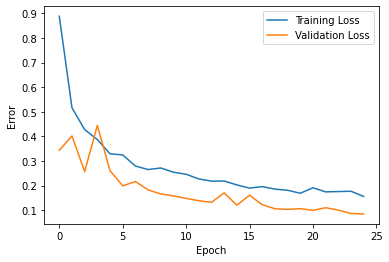

In [36]:
train_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(train_loss , label = "Training Loss")
plt.plot(validation_loss , label = "Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()

In [37]:
model.evaluate(Xtrain,ytrain)

34/34 [==============================] - 0s 14ms/step - loss: 0.0849


0.0848882794380188

In [38]:
# np.mean(history.history["accuracy"])

In [39]:
(1 - np.mean(history.history["loss"]))*100

72.62346333265303

## accuracy plot

# FUTURE FORECAST: 

### GENERATING DATES SEQUENCE

In [40]:
nFut = 90

In [41]:
futureDates = pd.date_range(dates[-1], periods=nFut, freq='1d').tolist()

In [42]:
futureDatesList = []
for i in futureDates:
    futureDatesList.append(i.date())

In [43]:
futureDatesList[-1]

datetime.date(2022, 8, 15)

### MODEL PREDICTIONS

In [44]:
futurePreds = model.predict(Xtrain[-nFut:])
trainPreds = model.predict(Xtrain[nPast:])

### INVERSE SCALING

In [45]:
y_predFuture = pred_sc.inverse_transform(futurePreds)
y_predTrain = pred_sc.inverse_transform(trainPreds)

In [46]:
def to_Timestamp(x):
    return dt.datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')

In [47]:
FUT_PREDS = pd.DataFrame(y_predFuture, columns=["Open"]).set_index(pd.Series(futureDatesList))
TRAIN_PREDS = pd.DataFrame(y_predTrain, columns=["Open"]).set_index(pd.Series(dates[2 * nPast + nFuture - 1:]))

In [48]:
TRAIN_PREDS.index = TRAIN_PREDS.index.to_series().apply(to_Timestamp)

In [49]:
TRAIN_PREDS.head(2)

,Open
2018-02-13,78.244537
2018-02-14,78.230392


### FOR VISUALIZATION PURPOSE: 

In [50]:
trainSet = pd.DataFrame(data, columns=features)
trainSet.index = dates
trainSet.index = pd.to_datetime(trainSet.index)

In [51]:
trainSet.head(2)

,Open,High,Low,Close
2018-01-01,67.0,67.69,67.0,67.20
2018-01-02,67.0,70.56,67.0,70.56


In [52]:
TRAIN_PREDS.index[0]

Timestamp('2018-02-13 00:00:00')

# FORECAST VISUALISATION

In [53]:
from pylab import rcParams

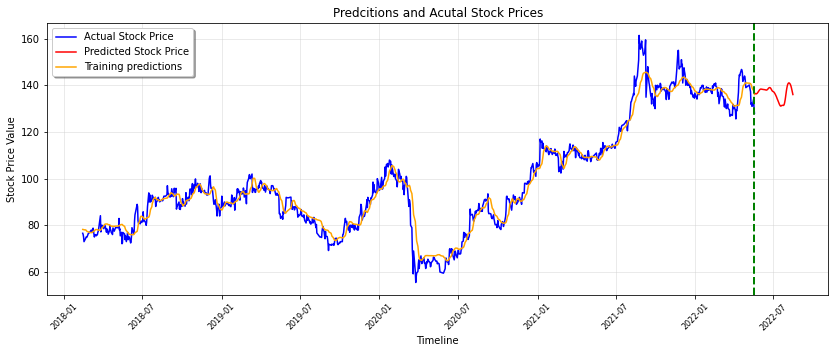

In [54]:
rcParams['figure.figsize'] = 14, 5

# Plotting
STARTDATE = TRAIN_PREDS.index[0]

plt.plot(trainSet.loc[STARTDATE:].index, trainSet.loc[STARTDATE:]["Open"], color='blue', label='Actual Stock Price')
plt.plot(FUT_PREDS.index, FUT_PREDS["Open"], color='red', label='Predicted Stock Price')
plt.plot(TRAIN_PREDS.loc[STARTDATE:].index, TRAIN_PREDS.loc[STARTDATE:]["Open"], color='orange', label='Training predictions')

plt.axvline(x = min(FUT_PREDS.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', fontsize=12)
plt.xlabel('Timeline', fontsize=10)
plt.ylabel('Stock Price Value', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

In [55]:
model.save("model0.h5")

In [56]:
from plotly.offline import download_plotlyjs , iplot , init_notebook_mode , plot

In [57]:
init_notebook_mode(connected=True)

In [58]:
import cufflinks as cf

In [88]:
cf.go_offline()

In [60]:
FUT_PREDS.iplot()

In [61]:
import plotly.express as px

In [71]:
fig = px.line(
    x=futureDatesList, y=FUT_PREDS["Open"] , height = 500
)

In [72]:
fig.show()

In [89]:
import plotly.graph_objects as go

In [90]:
fg = go.Figure()

In [95]:
fg.add_trace(go.Scatter(
    x = trainSet.loc[STARTDATE:].index,
    y = trainSet.loc[STARTDATE:]["Open"],
    line=dict(color='blue') , showlegend= False , name = 'Actual Stock Price'
))

fg.add_trace(go.Scatter(
    x = FUT_PREDS.index,
    y = FUT_PREDS["Open"],
    line=dict(color='orange'), showlegend= False , name = 'Predicted Train Price'
))

fg.add_trace(go.Scatter(
    x = TRAIN_PREDS.loc[STARTDATE:].index,
    y = TRAIN_PREDS.loc[STARTDATE:]["Open"], 
    line=dict(color='red'), showlegend= False , name = 'Future Predicted Price'
))

fg.update_layout(
    title="Pred vs. Actual",
    xaxis_title="Time",
    yaxis_title="Stock Open Prices",
    height = 500 ,
    width = 900
)

fg.show()
